## Betting Algorithm

### Introduction
The goal of this notebook is to develop a algorithm based off a match predicting model. In this notebook, the model of choice ix xgb_v1, and compatible datasets for training and backtesting are selected.

Given two players and match context, the model is able to produce an expectation that a player is going to win. The underlying algorithm calculates fair odds for betting. If there is enough margin, the algorithm bets.

### Data

In [238]:
import numpy as np
import pandas as pd

def get_data():
    train_df = pd.read_parquet("../../data/training_data/dataset_v1.parquet")
    backtest_df = pd.read_parquet("../../data/backtest/backtest_v1.parquet")

    return train_df, backtest_df

train_df, backtest_df = get_data()

The model will be trained with data from `training_data\dataset_v1.parquet` until some specified time. The backtest will run from when the training period ends.

In [239]:
train_end_date = 20221231

train_df = train_df[train_df["tourney_date"] <= train_end_date]
backtest_df = backtest_df[backtest_df["tourney_date"] > train_end_date]

print(train_df.columns)


Index(['draw_size', 'tourney_date', 'best_of', 'order', 'hth_win_p_a',
       'surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard',
       'tourney_level_A', 'tourney_level_F', 'tourney_level_G',
       'tourney_level_M', 'hand_a_A', 'hand_a_L', 'hand_a_R', 'hand_a_U',
       'hand_b_A', 'hand_b_L', 'hand_b_R', 'hand_b_U', 'round_BR', 'round_ER',
       'round_F', 'round_QF', 'round_R128', 'round_R16', 'round_R32',
       'round_R64', 'round_RR', 'round_SF', 'elo_diff', 'elo_surface_diff',
       'p_ace_diff', 'p_df_diff', 'p_1stIn_diff', 'p_1stWon_diff',
       'p_2ndWon_diff', 'p_2ndWon_inPlay_diff', 'p_bpSaved_diff', 'p_rpw_diff',
       'p_retAceAgainst_diff', 'p_ret1stWon_diff', 'p_ret2ndWon_diff',
       'p_ret2ndWon_inPlay_diff', 'p_bpConv_diff', 'p_totalPtsWon_diff',
       'dominance_ratio_diff', 'age_diff', 'ht_diff', 'form_delta_diff',
       'elo_momentum_diff', 'recent_minutes_diff', 'log_rank_points_diff',
       'log_total_matches_diff', 'log_total_surface_m

### Model
The model is imported and trained with data until end of 2005.

In [ ]:
import pickle

cols_to_drop = ['recent_minutes_diff',
       'log_total_surface_matches_diff',
       'log_recent_matches_diff',
       'result']

def get_trained_model(train_df):
    with open("../../models/xgb_v1.pkl", "rb") as f:
        model = pickle.load(f)

    X = train_df.drop(columns=cols_to_drop)
    y = train_df["result"]

    model.fit(X, y)

    return model

model_xgb_v1 = get_trained_model(train_df)


### Base Algorithm

The most basic algorithm takes in a predicted probability of winning and odds. The algorithm will then trade if it finds a large enough margin. It also bets a fixed amount every match.

The predicted probabilities are precomputed to utilise xgboost's parallel processing.


In [241]:
feature_cols = train_df.columns.drop(cols_to_drop)

# precompute predicted probabilities
X = backtest_df[feature_cols]
probs_a = model_xgb_v1.predict_proba(X)[:, 1]
backtest_df = backtest_df.copy()
backtest_df["prob_a_xgb_v1"] = probs_a

def basic_algorithm(row, odds_a, odds_b, bankroll=2000, margin=0):
    """
    Basic algorithm that bets a fixed amount every match. Returns positive if betting on A, negative if betting on B.
    """
    prob_a = row["prob_a_xgb_v1"]
    fair_odds_a = 1 / prob_a
    fair_odds_b = 1 / (1 - prob_a)

    bet_size = bankroll * 0.05
    if odds_a > fair_odds_a + margin:
        return bet_size
    elif odds_b > fair_odds_b + margin:
        return -bet_size

    return 0

In [242]:
row = backtest_df.loc[backtest_df["B365W"].idxmin()]
row

name_a            Carlos Alcaraz
name_b                     Li Tu
id_a                      207989
id_b                      111454
score            6-2 4-6 6-3 6-1
                      ...       
hand_a_A                       0
hand_b_A                       0
round_BR                       0
round_ER                       0
prob_a_xgb_v1           0.956991
Name: 40053, Length: 95, dtype: object

### Backtest Engine

The backtester expects a betting algorithm, and reads the odds and keeps track of a balance. Commission is optional, and is only applied to winnings. 

The backtester returns a list of the balances over each bet.

In [243]:
def get_odds(row):
    # find odds, use b365 if available, otherwise use ps
    if pd.notna(row["B365W"]) and pd.notna(row["B365L"]):
        odds_w = row["B365W"]
        odds_l = row["B365L"]
    elif pd.notna(row["PSW"]) and pd.notna(row["PSL"]):
        odds_w = row["PSW"]
        odds_l = row["PSL"]
    else:
        return None, None
    
    result = row["result"]
    if result == 1:
        odds_a = odds_w
        odds_b = odds_l
    else:
        odds_a = odds_l
        odds_b = odds_w
    
    return odds_a, odds_b

def backtester(backtest_df, algorithm, starting_balance=2000, commission=0):
    balance = starting_balance
    balance_history = [balance]
    return_history = []

    for index, row in backtest_df.iterrows():
        
        odds_a, odds_b = get_odds(row)
        if odds_a is None:
            balance_history.append(balance)
            return_history.append(0)
            continue
        
        bet = algorithm(row, odds_a, odds_b, bankroll=balance)

        result = row["result"]

        if bet is None or pd.isna(bet) or bet == 0:
            balance_history.append(balance)
            return_history.append(0)
            continue

        stake = abs(bet)
        balance_before = balance

        if (bet > 0 and result == 1) or (bet < 0 and result == 0):
            # Win
            odds = odds_a if bet > 0 else odds_b
            gross_profit = stake * (odds - 1)

            # apply commission only on winnings
            net_profit = gross_profit * (1 - commission)
            balance += net_profit
        else:
            # Loss
            balance -= stake

        return_history.append((balance - balance_before) / stake * 100)
        balance_history.append(balance)

    return balance_history, return_history


### Running the Backtester

We first run the backtester on the base algorithm.

In [244]:
balance_history, return_history = backtester(backtest_df, basic_algorithm, commission=0)

Visualising the results:

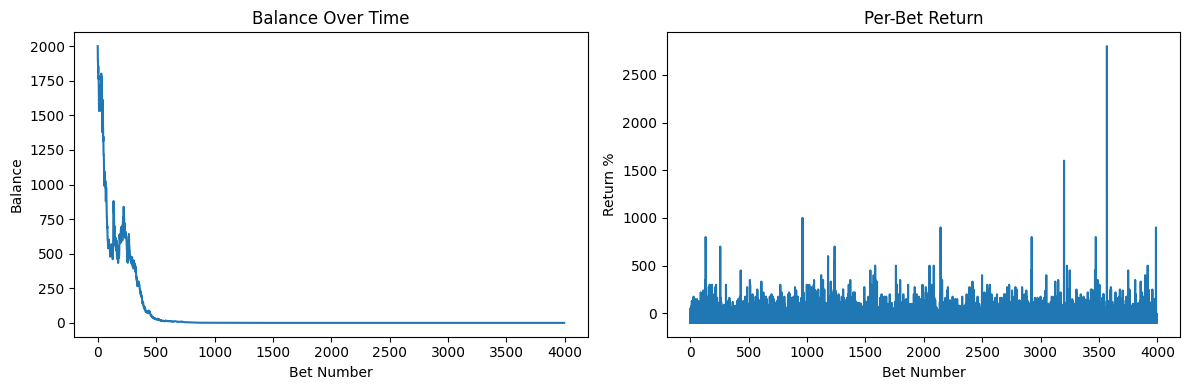

Ending Bankroll: 1.7430902371851806e-06
Total bets: 3022
Win rate: 0.4192587690271343
Average return: -9.630377233620118
Max return: 2800.0
Min return: -100.0000000000002


In [245]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: balance over time
axes[0].plot(balance_history)
axes[0].set_xlabel("Bet Number")
axes[0].set_ylabel("Balance")
axes[0].set_title("Balance Over Time")

# Right: per-bet returns
axes[1].plot(return_history)
axes[1].set_xlabel("Bet Number")
axes[1].set_ylabel("Return %")
axes[1].set_title("Per-Bet Return")

plt.tight_layout()
plt.show()

# print statistics
bets_made = np.count_nonzero(np.array(return_history))

print(f"Ending Bankroll: {balance_history[-1]}")
print(f"Total bets: {bets_made}")
print(f"Win rate: {np.sum(np.array(return_history) > 0) / bets_made}")
print(f"Average return: {sum(return_history) / bets_made}")
print(f"Max return: {max(return_history)}")
print(f"Min return: {min(return_history)}")

## Conclusion
Some features contain obvious artefacts of data leakage and have been removed in evaluation. Although the algorithm is theoretically sound, it heavily depends on a good fair odds calculator. Because the current model is inaccurate in its predictions, the algorithm appears highly unprofitable.

Although the algorithm has not yielded positive results, I have learnt and discovered a few things.

### 1. Calibration vs Profitability
A well calibrated model does not mean it is profitable in practice. Here, the XGB_v1 model is well calibrated, with Brier score of 0.1713 and ECE score of 0.0126. This means on average, the predicited probabilities reflect the true frequency of the events. However, this is true only **on average**. 

In the bucket of matches where the model predicts A to win 60% of the time, A is shown to have won 60% of the time. However the average **does not** reflect the true probability of any single match. For some matches, the true unknown probability may be higher than 60%, and for others, it may be lower. The combined effect is still A wins 60% of the time, but the probability of each individual match varies.

If the market has more accurate probabilities than our model, then every disagreement between us reflects an inefficiency in our pricing, not theirs. For instance, suppose our model estimates Player A’s win probability at 60% and we therefore set fair odds at 1.67. If the market offers 1.50, we interpret that as value and place a bet. But because the market’s estimate of the true probability is superior, this trade is an expected loss. In other words, even though our model may appear perfectly calibrated in aggregate, the market still outperforms us on a match by match basis.

In summary, calibration is not at all an indication of profitability. A well calibrated model can still be incredibly negative.

### 2. Model Selection
Here, XGBoost is chosen as the target model for tennis match prediction. XGBoost is a model specialised for tabular data, whereas tennis prediction is a game with a continuous flow of data. New information comes in, and old information slowly decays into irrelevance. XGBoost has no inherent built in recognition of this temporal difference between data.

To help XGBoost understand the sequential flow of information, features with EWMA and skill estimation features such as Glicko-2 and Kalman Filters have tried to bake in the idea that recent data matters more than past data. However, because of XGBoost's inherent tabular nature, this form of feature engineering seems counterproductive. 

Instead of manually hacking time relevance into XGBoost, I want to experiment with online learning, where the sequential flow of new information is naturally considered. I'm not sure exactly what model is optimal, and experimentation will be conducted.

Now or later down the line, I want to switch to using a point by point dataset. This will enable the models to learn the nuances behind each player that cannot be inferred from simple match statistics. An initial vision I have is monte carlo simulation of tennis matches, combined with a point prediction engine. This will also let me price other bets, such as first set winner and so on.

### 3. Adverse Selection
Adverse selection is arguably the most important factor in designing a sports betting algorithm. Although many variables in sports betting are unpredictable, there exists a single unwavering truth. The market's models are better. If I want to design a profitable betting algorithm, I cannot depend on my model being more accurate. I'll need to find an edge elsewhere.

What happens to the average return when the margin on for the fair odds algorithm is increased? A naive way to think is to think of the margin as room for error. If I increase the margin, I am being more selective with my bets and discarding potential bad bets. Hence, the average return should increase.

However, this assumes that the true value is distributed centered around my prediction. Under this assumption, if the difference between market odds and my odds increases, the probability that the true odds is below the market odds should increase. However, this assumption is not at all true. In fact, the true odds is more likely to be distributed around the market odds. This means as the margin increases, my predicted odds stray further from the true odds, and hence the average return should decrease. This is exactly what is observed.

Hence, when designing a trading algorithm, a valid assumption to make is that the distribution of the true odds centered closer to the market odds than my predicted odds no matter the model. A prediction model alone will never beat the market, and will have to be used in clever ways to scalp an edge. For example, I could try market making instead of pure prediction of who is going to win.

### Next Steps
- Point based data & Monte Carlo Simulation
- Online Learning Experimentation
- Always consider adverse selection




